In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def print_values(title, params, color):
    # Define color escape sequences
    bold = "\033[1m"
    end_color = "\033[0m"
    yellow = "\033[93m"

    print(f"{bold}num_objects: {yellow}{num_objects}{end_color}, {bold}num_movements: {yellow}{num_movements}{end_color}")

    
    # Define color and font escape sequences
    bold = "\033[1m"
    red = "\033[91m"
    blue = "\033[94m"
    end_color = "\033[0m"

    # Print the title
    print("\n" + bold + title + end_color)

    # Print the first three parameters in a single line
    print(red + "{:<5s} = {:<10.4f}, {:<5s} = {:<10.4f}, {:<5s} = {:<10.4f}".format("X0", params['X0'], "Y0", params['Y0'], "Z0", params['Z0']) + end_color)

    # Print the rest of the parameters
    print(blue + "{:<5s} = {}".format("x", ", ".join("{:.4f}".format(val) for val in params['x'][:10])) + end_color)
    print(blue + "{:<5s} = {}".format("y", ", ".join("{:.4f}".format(val) for val in params['y'][:10])) + end_color)
    print(blue + "{:<5s} = {}".format("z", ", ".join("{:.4f}".format(val) for val in params['z'][:10])) + end_color)


def print_initial_parameters(initial_params):
    print_values("Initial parameters:", initial_params, "\033[91m") # Red color

def print_final_parameters(final_params):
    print_values("Learned parameters:", final_params, "\033[94m")  # Blue color

def print_parameters(initial_params, final_params):
    print_initial_parameters(initial_params)

    print_final_parameters(final_params)

In [3]:
np.random.seed(0)  # for reproducibility

num_objects = 16
num_movements = 4

# Generate random movements for the light source
deltaXs = np.random.uniform(-10, 10, size=num_movements)
deltaYs = np.random.uniform(-10, 10, size=num_movements)
deltaZs = np.random.uniform(-10, 10, size=num_movements)

# Known parameters
X0_true = 0.0
Y0_true = 0.0
Z0_true = 100.0
# z_true = np.array([1.0]*num_objects)
z_true = np.random.uniform(0.5, 1.5, num_objects)

# x_true = np.array([15.0, 17.0, 13.0])  # x-coordinates of objects
# y_true = np.array([25.0, 22.0, 27.0])  # y-coordinates of objects
# num_objects = len(x_true)  # number of objects

def generate_object_coordinates(num_objects):
    np.random.seed(0)  # for reproducibility
    x_true = np.random.normal(0, 3, size=num_objects)
    y_true = np.random.normal(0, 3, size=num_objects)

    return x_true, y_true


x_true, y_true = generate_object_coordinates(num_objects)


# Define the function for the shadow's x-coordinate
def shadow_x(X0, Z0, deltaX, deltaZ, x1, z1):
    return X0 + deltaX - ((X0 + deltaX - x1) / (Z0 + deltaZ - z1)) * (Z0 + deltaZ)

# Define the function for the shadow's y-coordinate
def shadow_y(Y0, Z0, deltaY, deltaZ, y1, z1):
    return Y0 + deltaY - ((Y0 + deltaY - y1) / (Z0 + deltaZ - z1)) * (Z0 + deltaZ)


# deltaXs = np.random.normal(0, 3, size=num_movements)
# deltaYs = np.random.normal(0, 3, size=num_movements)
# deltaZs = np.random.normal(0, 3, size=num_movements)

# Calculate the corresponding shadow locations for each object
x_shadows = [[shadow_x(X0_true, Z0_true, deltaX, deltaZ, xi_true, zi_true) for deltaX, deltaZ in zip(deltaXs, deltaZs)] for xi_true, zi_true in zip(x_true, z_true)]
y_shadows = [[shadow_y(Y0_true, Z0_true, deltaY, deltaZ, yi_true, zi_true) for deltaY, deltaZ in zip(deltaYs, deltaZs)] for yi_true, zi_true in zip(y_true, z_true)]

deltaXs, deltaYs, deltaZs

(array([0.97627008, 4.30378733, 2.05526752, 0.89766366]),
 array([-1.52690401,  2.91788226, -1.24825577,  7.83546002]),
 array([ 9.27325521, -2.33116962,  5.83450076,  0.5778984 ]))


Epoch 10000/100000, Loss: 0.0004821582406293601

Epoch 20000/100000, Loss: 6.4407904574181885e-06

Epoch 30000/100000, Loss: 4.4114639763392915e-07

Epoch 40000/100000, Loss: 5.8553432324970345e-08

Epoch 50000/100000, Loss: 8.331919154613843e-09

Epoch 60000/100000, Loss: 8.372773407927525e-08

Epoch 70000/100000, Loss: 1.5600271296989376e-08

Epoch 80000/100000, Loss: 2.647385244358702e-08

Epoch 90000/100000, Loss: 1.7952377362462357e-08

Epoch 100000/100000, Loss: 5.476517017655169e-09
num_objects: 16, num_movements: 4

Initial parameters:
X0    = 0.0000    , Y0    = 0.0000    , Z0    = 100.0000  
x     = 5.2922, 1.2005, 2.9362, 6.7227, 5.6027, -2.9318, 2.8503, -0.4541, -0.3097, 1.2318
y     = 4.4822, -0.6155, 0.9392, -2.5623, -7.6590, 1.9609, 2.5933, -2.2265, 6.8093, -4.3631
z     = 1.4683, 0.8326, 1.0195, 0.7259, 0.7347, 1.4385, 1.1505, 0.6980, 1.1158, 1.0144
num_objects: 16, num_movements: 4

Learned parameters:
X0    = -0.0006   , Y0    = 0.0012    , Z0    = 99.9183   
x     =

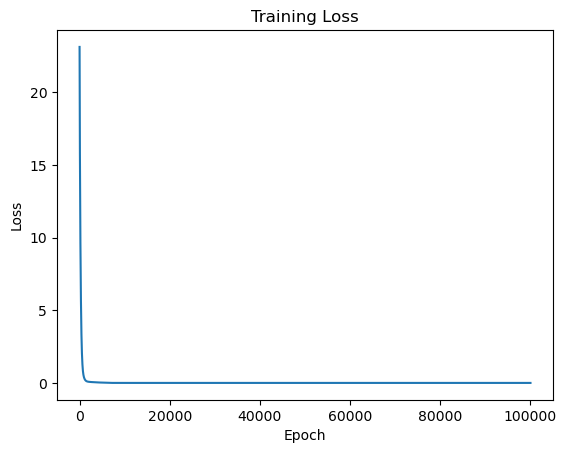

In [4]:
class ShadowNet(nn.Module):
    def __init__(self, num_objects):
        super(ShadowNet, self).__init__()
        self.X0 = nn.Parameter(torch.randn(1))
        self.Y0 = nn.Parameter(torch.randn(1))
        self.Z0_raw = nn.Parameter(torch.randn(1))  # will apply softplus and add 10*z
        self.x = nn.Parameter(torch.randn(num_objects))
        self.y = nn.Parameter(torch.randn(num_objects))
        self.z_raw = nn.Parameter(torch.randn(num_objects))  # will apply softplus
        
        self.zoom = 10

    @property
    def Z0(self):
        Z0_raw = torch.nn.functional.softplus(self.Z0_raw)
        z = self.z
        return Z0_raw + self.zoom*z.mean()

    @Z0.setter
    def Z0(self, value):
        self.Z0_raw.data = torch.tensor([value.item() - self.zoom*self.z.mean()])

    @property
    def z(self):
        return torch.nn.functional.softplus(self.z_raw)

    @z.setter
    def z(self, value):
        self.z_raw.data = torch.tensor([value.item()])

    def forward(self, deltaX, deltaY, deltaZ):
        deltaX = deltaX.unsqueeze(-1).expand(-1, num_objects)  # shape (num_movements, num_objects)
        deltaY = deltaY.unsqueeze(-1).expand(-1, num_objects)
        deltaZ = deltaZ.unsqueeze(-1).expand(-1, num_objects)
        z = self.z.unsqueeze(0).expand(num_movements, num_objects)  # shape (num_movements, num_objects)
        x_shadows = self.X0 + deltaX - ((self.X0 + deltaX - self.x) / (self.Z0 + deltaZ - z)) * (self.Z0 + deltaZ)
        y_shadows = self.Y0 + deltaY - ((self.Y0 + deltaY - self.y) / (self.Z0 + deltaZ - z)) * (self.Z0 + deltaZ)
        return x_shadows, y_shadows



# Initialize the network
net = ShadowNet(num_objects)

# Set the initial parameters of the network to the known parameters
with torch.no_grad():
    net.X0.copy_(torch.tensor([X0_true]))
    net.Y0.copy_(torch.tensor([Y0_true]))
    net.Z0.copy_(torch.tensor([Z0_true]))
    net.x.copy_(torch.tensor(x_true))
    net.y.copy_(torch.tensor(y_true))
    net.z.copy_(torch.tensor(z_true))

# Check the output of the network before training
inputs = torch.tensor(list(zip(deltaXs, deltaYs, deltaZs)), dtype=torch.float32)
x_shadows_true = torch.tensor(x_shadows, dtype=torch.float32)
y_shadows_true = torch.tensor(y_shadows, dtype=torch.float32)
# print("Inputs: \n", inputs)
# print("Shadows' location (direct calculation): \n", x_shadows_true, y_shadows_true)

# output_before_training = net(*inputs.unbind(dim=1))
# print("Output before training:")
# print(output_before_training)

# Define a function to reset the parameters of the network
def reset_parameters(model):
    for param in model.parameters():
        param.data.normal_(0, 3)

# Reset the parameters of the network
reset_parameters(net)

# Check the output of the network after resetting the parameters
# output_after_reset = net(*inputs.unbind(dim=1))
# print("\nOutput after resetting the parameters:")
# print(output_after_reset)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)
# optimizer = optim.RAdam(net.parameters(), lr=0.01)
# optimizer = optim.SGD(net.parameters(), lr=0.01)
# optimizer = optim.RMSprop(net.parameters(), lr=0.01)

# Train the network
best_loss = float('inf')
best_model_params = None

# Train the network
losses = []
for epoch in range(100000):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = net(*inputs.unbind(dim=1))
    loss = criterion(torch.cat(outputs).T, torch.cat((x_shadows_true, y_shadows_true), axis=-1))

    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    
    # Save the best model
    if loss.item() < best_loss:
        best_loss = loss.item()
        best_model_params = net.state_dict().copy()

    # Print the loss every 1000 epochs
    if (epoch + 1) % 10000 == 0:
        print(f"\nEpoch {epoch+1}/{100000}, Loss: {loss.item()}")
    
    losses.append(loss.item())
    
# Load the best model parameters
net.load_state_dict(best_model_params)

initial_params = {
    'X0': X0_true,
    'Y0': Y0_true,
    'Z0': Z0_true,
    'x': x_true,
    'y': y_true,
    'z': z_true
}

final_params = {
    'X0': net.X0.item(),
    'Y0': net.Y0.item(),
    'Z0': net.Z0.item(),
    'x': net.x.detach().numpy(),
    'y': net.y.detach().numpy(),
    'z': net.z.detach().numpy()
}

print_parameters(initial_params, final_params)

# Visualization of the training process
plt.figure()
plt.plot(losses[:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [7]:
print_parameters(initial_params, final_params)

num_objects: 16, num_movements: 4

Initial parameters:
X0    = 0.0000    , Y0    = 0.0000    , Z0    = 100.0000  
x     = 5.2922, 1.2005, 2.9362, 6.7227, 5.6027, -2.9318, 2.8503, -0.4541, -0.3097, 1.2318
y     = 4.4822, -0.6155, 0.9392, -2.5623, -7.6590, 1.9609, 2.5933, -2.2265, 6.8093, -4.3631
z     = 1.4683, 0.8326, 1.0195, 0.7259, 0.7347, 1.4385, 1.1505, 0.6980, 1.1158, 1.0144
num_objects: 16, num_movements: 4

Learned parameters:
X0    = -0.0006   , Y0    = 0.0012    , Z0    = 99.9183   
x     = 5.2921, 1.2005, 2.9362, 6.7227, 5.6029, -2.9319, 2.8503, -0.4540, -0.3096, 1.2318
y     = 4.4822, -0.6155, 0.9392, -2.5623, -7.6593, 1.9609, 2.5934, -2.2265, 6.8092, -4.3631
z     = 1.4672, 0.8319, 1.0187, 0.7253, 0.7343, 1.4373, 1.1496, 0.6974, 1.1149, 1.0135


In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_movements(X0, Y0, Z0, deltaXs, deltaYs, deltaZs, x_true, y_true, z_true, x_shadows, y_shadows, num_movements=3):
    # Prepare data for plotting
    light_source = np.array([[X0 + deltaXs[i], Y0 + deltaYs[i], Z0 + deltaZs[i]] for i in range(num_movements)])
    objects = np.array([x_true, y_true, z_true]).T
    shadows = [np.array([x_shadows[i][:num_movements], y_shadows[i][:num_movements], np.zeros(num_movements)]).T for i in range(len(x_true))]

    # Handle case when num_movements is equal to 1
    if num_movements == 1:
        # Create a single plot
        fig = plt.figure(figsize=(6, 6))
        ax = fig.add_subplot(111, projection='3d')

        # Plot light source
        ax.scatter(*light_source[0], color='y', label='Light Source')

        # Plot objects
        ax.scatter(*objects.T, color='b', label='Objects')

        # Plot shadows
        for shadow in shadows:
            ax.scatter(*shadow[0], color='r', alpha=0.5)

        ax.set_title('Movement 1')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.legend()
        ax.view_init(elev=20., azim=-35)

    else:
        # Create multiple subplots
        fig, axs = plt.subplots(1, num_movements, figsize=(6*num_movements, 6), subplot_kw={'projection': '3d'})

        for i in range(num_movements):
            # Plot light source
            axs[i].scatter(*light_source[i], color='y', label='Light Source')

            # Plot objects
            axs[i].scatter(*objects.T, color='b', label='Objects')

            # Plot shadows
            for shadow in shadows:
                axs[i].scatter(*shadow[i], color='r', alpha=0.5)

            axs[i].set_title(f'Movement {i+1}')
            axs[i].set_xlabel('X')
            axs[i].set_ylabel('Y')
            axs[i].set_zlabel('Z')
            axs[i].legend()
            axs[i].view_init(elev=20., azim=-35)

    plt.tight_layout()
    plt.show()


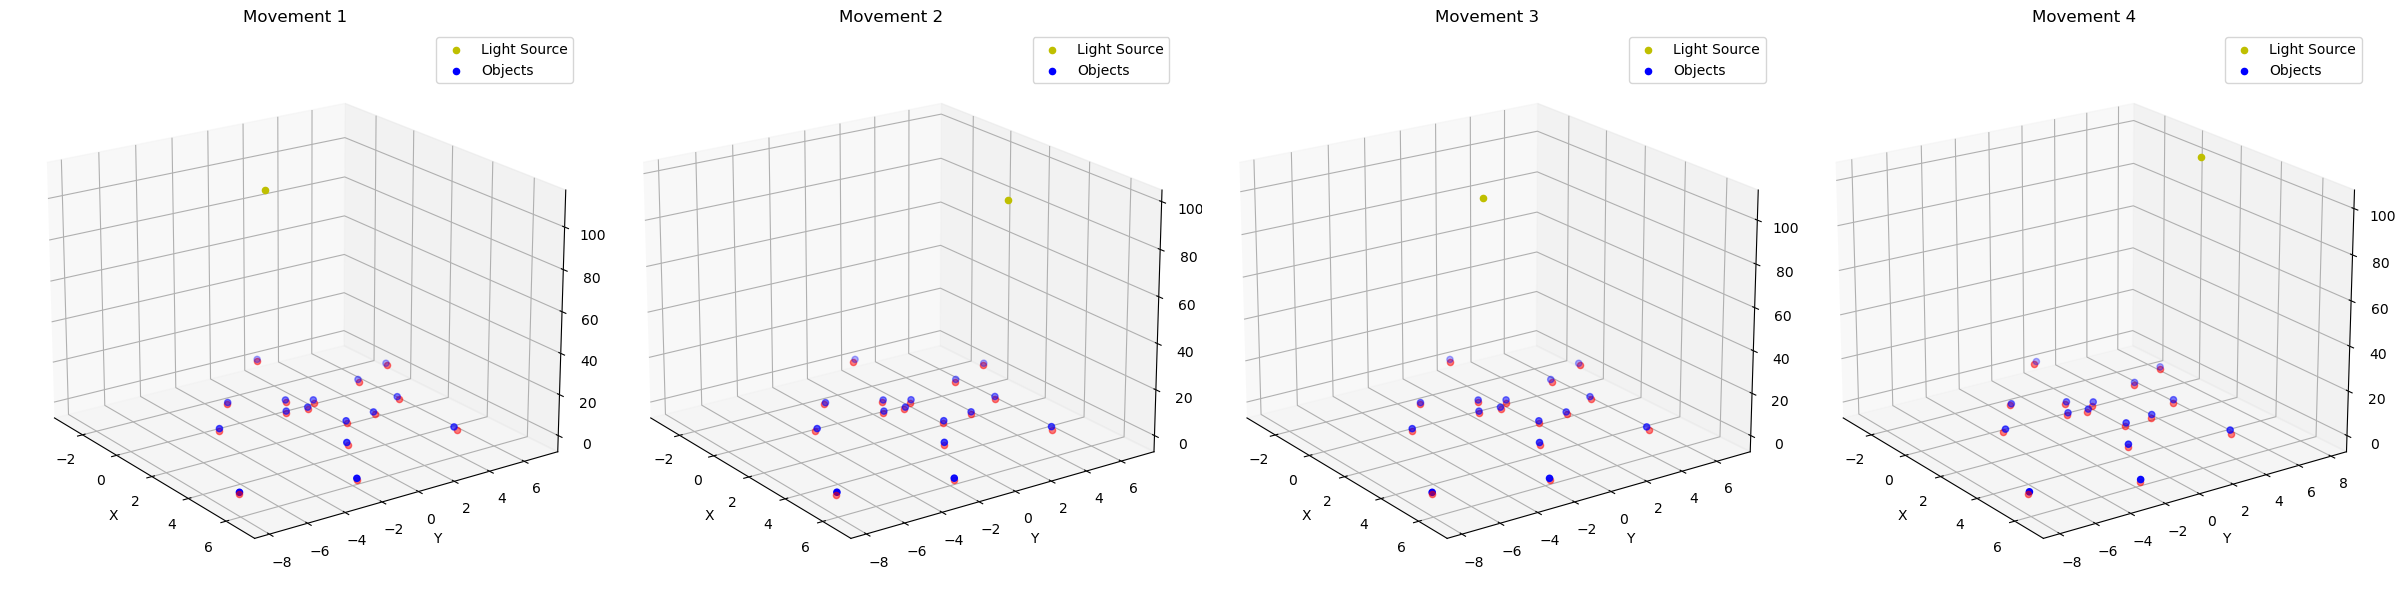

num_objects: 16, num_movements: 4

Initial parameters:
X0    = 0.0000    , Y0    = 0.0000    , Z0    = 100.0000  
x     = 5.2922, 1.2005, 2.9362, 6.7227, 5.6027, -2.9318, 2.8503, -0.4541, -0.3097, 1.2318
y     = 4.4822, -0.6155, 0.9392, -2.5623, -7.6590, 1.9609, 2.5933, -2.2265, 6.8093, -4.3631
z     = 1.4683, 0.8326, 1.0195, 0.7259, 0.7347, 1.4385, 1.1505, 0.6980, 1.1158, 1.0144


In [9]:
# # Calculate the corresponding shadow locations for each object
# x_shadows = [[shadow_x(X0_true, Z0_true, deltaX, deltaZ, xi_true) for deltaX, deltaZ in zip(deltaXs, deltaZs)] for xi_true in x_true]
# y_shadows = [[shadow_y(Y0_true, Z0_true, deltaY, deltaZ, yi_true) for deltaY, deltaZ in zip(deltaYs, deltaZs)] for yi_true in y_true]


# Plot the movements
plot_movements(X0_true, Y0_true, Z0_true, deltaXs, deltaYs, deltaZs, x_true, y_true, z_true, x_shadows, y_shadows, num_movements=4)
print_initial_parameters(initial_params)

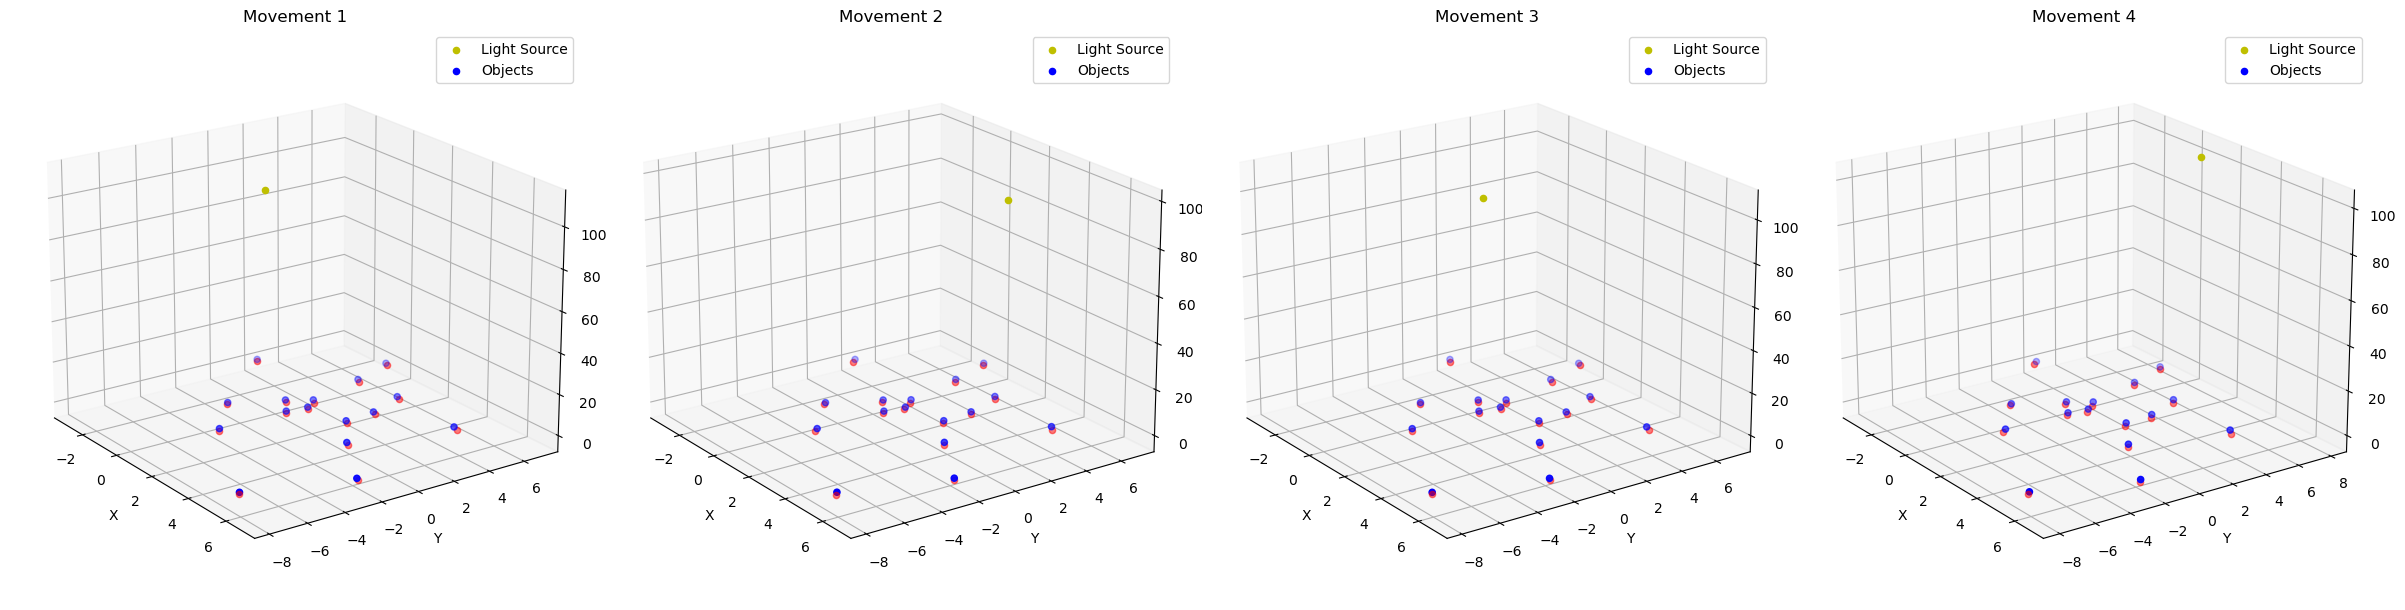

num_objects: 16, num_movements: 4

Learned parameters:
X0    = -0.0006   , Y0    = 0.0012    , Z0    = 99.9183   
x     = 5.2921, 1.2005, 2.9362, 6.7227, 5.6029, -2.9319, 2.8503, -0.4540, -0.3096, 1.2318
y     = 4.4822, -0.6155, 0.9392, -2.5623, -7.6593, 1.9609, 2.5934, -2.2265, 6.8092, -4.3631
z     = 1.4672, 0.8319, 1.0187, 0.7253, 0.7343, 1.4373, 1.1496, 0.6974, 1.1149, 1.0135


In [10]:
# Check the output of the network after training
output_after_training = net(*inputs.unbind(dim=1))

# Convert the output to numpy arrays
x_shadows_pred = output_after_training[0].detach().numpy().T
y_shadows_pred = output_after_training[1].detach().numpy().T

# Get the learned parameters from the model
X0_learned = net.X0.item()
Y0_learned = net.Y0.item()
Z0_learned = net.Z0.item()
x_learned = net.x.detach().numpy()
y_learned = net.y.detach().numpy()
z_learned = net.z.detach().numpy()

# Plot the movements using the learned parameters
plot_movements(X0_learned, Y0_learned, Z0_learned, deltaXs, deltaYs, deltaZs, x_learned, y_learned, z_learned, x_shadows_pred, y_shadows_pred, num_movements=4)
print_final_parameters(final_params)

In [ ]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Initialize the 3D plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot the light source
# ax.scatter([X0_true], [Y0_true], [Z0_true], c='y', marker='o', label='Light source')

# # Plot the objects
# ax.scatter(x_true, y_true, [z_true]*num_objects, c='r', marker='^', label='Objects')

# # Plot the shadows for each movement of the light source
# for i in range(num_movements):
#     ax.scatter(x_shadows[i], y_shadows[i], [0]*num_objects, c='b', marker='x', label='Shadows' if i == 0 else "")

# # Label the axes
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# # Add a legend
# ax.legend()

# # Show the plot
# plt.show()


In [ ]:
# # Plotting the first three movements

# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Prepare data for plotting
# light_source = np.array([[X0_true + deltaXs[i], Y0_true + deltaYs[i], Z0_true + deltaZs[i]] for i in range(3)])
# objects = np.array([x_true, y_true, np.repeat(z_true, num_objects)]).T
# shadows = [np.array([x_shadows[i][:3], y_shadows[i][:3], np.zeros(3)]).T for i in range(num_objects)]

# # Create plots
# fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': '3d'})

# for i in range(3):
#     # Plot light source
#     axs[i].scatter(*light_source[i], color='y', label='Light Source')

#     # Plot objects
#     axs[i].scatter(*objects.T, color='b', label='Objects')

#     # Plot shadows
#     for shadow in shadows:
#         axs[i].scatter(*shadow[i], color='r', alpha=0.5)

#     axs[i].set_title(f'Movement {i+1}')
#     axs[i].set_xlabel('X')
#     axs[i].set_ylabel('Y')
#     axs[i].set_zlabel('Z')
#     axs[i].legend()
#     axs[i].view_init(elev=20., azim=-35)

# plt.tight_layout()
# plt.show()
